In [11]:
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as pyplot
from numpy import mean
from numpy import std
#models we use:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
os.chdir(r'C:\Users\Bruger1\Documents\Data Science\3. Semester\Anvendt Maskinlæring\competition\X_test.npy')
#load data 
X_train = np.load('X_train.npy')
X_test= np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_train = y_train.ravel()

In [3]:
#Split and Scale Data 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify = y_train, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [5]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=3, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, perc=90, random_state=41) #90 is more lenient, to help reduce false negatives
#perc=100 equals original Boruta, Original Boruta have shown to be too stringent for biological data
feat_selector.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	204
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	204
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	204
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	204
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	204
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	204
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	204
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	24
Tentative: 	91
Rejected: 	89
Iteration: 	9 / 100
Confirmed: 	24
Tentative: 	91
Rejected: 	89
Iteration: 	10 / 100
Confirmed: 	24
Tentative: 	91
Rejected: 	89
Iteration: 	11 / 100
Confirmed: 	24
Tentative: 	91
Rejected: 	89
Iteration: 	12 / 100
Confirmed: 	24
Tentative: 	56
Rejected: 	124
Iteration: 	13 / 100
Confirmed: 	24
Tentative: 	56
Rejected: 	124
Iteration: 	14 / 100
Confirmed: 	24
Tentative: 	56
Rejected: 	124
Iteration: 	15 / 100
Confirmed: 	24
Tentative: 	56
Rejected: 	124
Iteration: 	16 / 100
Confirmed: 	24
T

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=149, n_jobs=3,
                                          random_state=RandomState(MT19937) at 0x2AA3A181540),
         n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x2AA3A181540, verbose=2)

In [ ]:
#24 features showed to be significantly better than the group of randomized permutations (the shadow features).

In [7]:
# call transform() on X to filter it down to selected features
#X_train = np.array(X_train)
X_train = feat_selector.transform(X_train)
X_test = feat_selector.transform(X_test)
X_val = feat_selector.transform(X_val)

In [16]:
######--- Defining functions
def get_models():
    #function call we use to fit all models
    models = dict()
    models['LogReg'] = LogisticRegression(penalty='none')
    models['Rf'] = RandomForestClassifier()
    models['cat'] = CatBoostClassifier()
    return models
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1,)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

## Creating Subsets
Because we have had relatively unsuccesful attempts at classifying class 1 as well as 0 and 2, it occurred to me that it would perhaps be easier to separate class 1 from 0, then class 1 from 2. We create three subsets, where we split the training set, test set and validation set, into sets of three = 9 subsets. X_train_0_1, X_train_1_2, and X_train_0_2 and so forth for validation and test. As we shall see, this actually solved the issue, and we achieve high classification performance on class 1 now too as well. 

In [9]:
#X_train contains 3 classes, i want to split the data into 3 subsets one subset with class 0, 1, next subset with classe 1,2 and one with class 0, 2
X_train = pd.DataFrame(X_train)
#append classes to use it as a training split criterion
X_train['Classes'] = y_train
#split the data into 3 subsets
X_train_0_1 = X_train.loc[(X_train['Classes'] == 0) | (X_train['Classes'] == 1)]
X_train_1_2 = X_train.loc[(X_train['Classes'] == 1) | (X_train['Classes'] == 2)]
X_train_0_2 = X_train.loc[(X_train['Classes'] == 0) | (X_train['Classes'] == 2)]
#split for y_train_
y_train_0_1 = X_train_0_1['Classes']
y_train_1_2 = X_train_1_2['Classes']
y_train_0_2 = X_train_0_2['Classes']
#drop classes again
X_train_0_1 = X_train_0_1.drop('Classes', axis=1)
X_train_1_2 = X_train_1_2.drop('Classes', axis=1)
X_train_0_2 = X_train_0_2.drop('Classes', axis=1)
#reset index for x_train_
X_train_0_1 = X_train_0_1.reset_index(drop=True)
X_train_1_2 = X_train_1_2.reset_index(drop=True)
X_train_0_2 = X_train_0_2.reset_index(drop=True)
#reset index for y_train_
y_train_0_1 = y_train_0_1.reset_index(drop=True)
y_train_1_2 = y_train_1_2.reset_index(drop=True)
y_train_0_2 = y_train_0_2.reset_index(drop=True)

### Evaluate Subset 0 and 1 Classification Performance

>LogReg 0.817 (0.007)
>Rf 0.853 (0.003)
>cat 0.915 (0.003)
LogReg 0.8165285151782804 0.006702389754188892
Rf 0.8530328425313792 0.0025548970515481494
cat 0.9154138222409479 0.0033043690431507375


{'whiskers': [<matplotlib.lines.Line2D at 0x2aa3f8b64c0>,
 'caps': [<matplotlib.lines.Line2D at 0x2aa3f8b6a00>,
 'boxes': [<matplotlib.lines.Line2D at 0x2aa3f8b6220>,
 'medians': [<matplotlib.lines.Line2D at 0x2aa3f8b6f40>,
 'fliers': [<matplotlib.lines.Line2D at 0x2aa3f8be4c0>,
 'means': [<matplotlib.lines.Line2D at 0x2aa3f8be220>,
  <matplotlib.lines.Line2D at 0x2aa3f8cfca0>]}

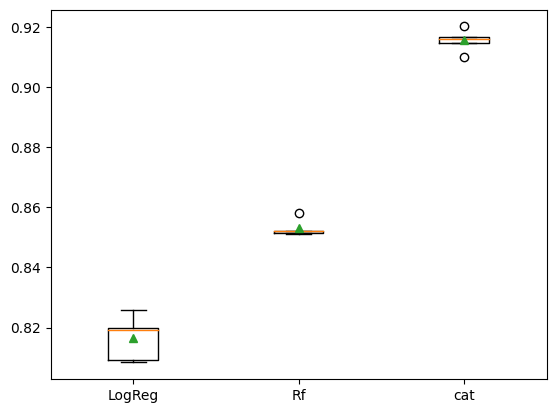

In [17]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results_01, names_01 = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_0_1, y_train_0_1) #<------- Cross validated performance 
    results_01.append(scores)
    names_01.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

for i in range(len(names_01)):
        print(names_01[i], mean(results_01[i]), std(results_01[i]))
# plot model performance for comparison
pyplot.boxplot(results_01, labels=names_01, showmeans=True)

### Evaluate Subset 1 and 2 Classification Performance

>LogReg 0.815 (0.003)
>Rf 0.864 (0.002)
>cat 0.935 (0.002)
LogReg 0.8147175527854962 0.0033045261190407156
Rf 0.864453156887452 0.0021686778071518652
cat 0.9350985792312191 0.0017007380172168155


{'whiskers': [<matplotlib.lines.Line2D at 0x2aa3f899df0>,
 'caps': [<matplotlib.lines.Line2D at 0x2aa3ed7f550>,
 'boxes': [<matplotlib.lines.Line2D at 0x2aa3fa238b0>,
 'medians': [<matplotlib.lines.Line2D at 0x2aa38a63610>,
 'fliers': [<matplotlib.lines.Line2D at 0x2aa38a63b50>,
 'means': [<matplotlib.lines.Line2D at 0x2aa38a638b0>,
  <matplotlib.lines.Line2D at 0x2aa38a8f370>]}

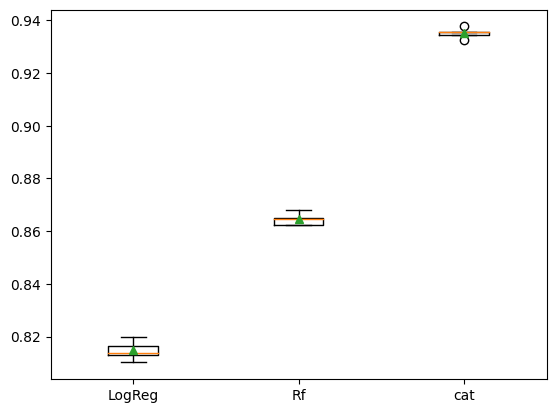

In [18]:
results_12, names_12 = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_1_2, y_train_1_2)
    results_12.append(scores)
    names_12.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

for i in range(len(names_01)):
        print(names_12[i], mean(results_12[i]), std(results_12[i]))
        
# plot model performance for comparison
pyplot.boxplot(results_12, labels=names_12, showmeans=True)

### Evaluate Subset 0 and 2 Classification Performance

>LogReg 0.938 (0.003)
>Rf 0.956 (0.003)
>cat 0.962 (0.004)
LogReg 0.9383690333269591 0.002949957082452295
Rf 0.9563763587355417 0.003102206539760583
cat 0.9619538416737352 0.0038468326409302396


{'whiskers': [<matplotlib.lines.Line2D at 0x2aa38c3dca0>,
 'caps': [<matplotlib.lines.Line2D at 0x2aa38acd220>,
 'boxes': [<matplotlib.lines.Line2D at 0x2aa38c3da00>,
 'medians': [<matplotlib.lines.Line2D at 0x2aa38acd760>,
 'fliers': [<matplotlib.lines.Line2D at 0x2aa38acdca0>,
 'means': [<matplotlib.lines.Line2D at 0x2aa38acda00>,
  <matplotlib.lines.Line2D at 0x2aa38af54c0>]}

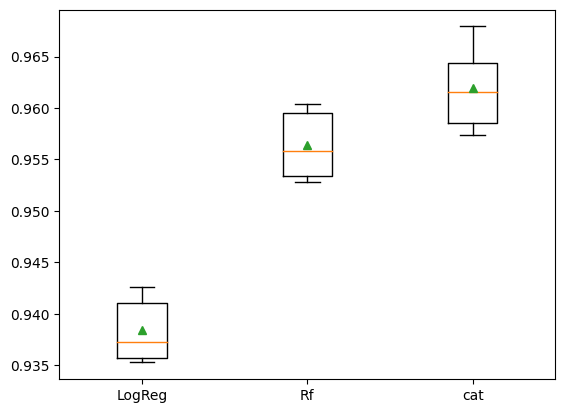

In [19]:
results_02, names_02 = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train_0_2, y_train_0_2)
    results_02.append(scores)
    names_02.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

for i in range(len(names_01)):
        print(names_02[i], mean(results_02[i]), std(results_02[i]))
# plot model performance for comparison
pyplot.boxplot(results_02, labels=names_02, showmeans=True)

Classes 0 and 2 are clearly the easiest to separate. Logistic Regression actually peforms competitively in this case, with a 93.8 percent accuracy. Catboost dominates performance in all cases: 91.5, 93.5 and 96.2 percent accuracy, respectively. Class 0 and 1 is definitely the most difficult to separate. 

#### To make things clear, 91.5, 93.5 and 96.2 is separately, much higher than classroom public leaderboard sporting a 90 percent accuracy for the entire dataset - which made me quite excited for the potential for the ensemble. 

We continue to work with CatBoost, we tune parameters for each subset, such that we hopefully can get a little more performance before we try to ensemble the predictions. 

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer #parameter ranges defined by these
opt = BayesSearchCV(CatBoostClassifier(),
     {
         'depth': Integer(1, 5), #default 6 
         'learning_rate': Real(0.1, 0.25), #default 0.03
         'l2_leaf_reg': Real(0.1, 3), #default 3
         'random_strength': Real(1, 10), #default 1
         'iterations': Integer(1000, 2000), #default 1000

     },
     n_iter=45,
     scoring='accuracy',
     return_train_score=True,
     cv = catcv,
     n_jobs=3,
     random_state=0
)

#first subset tuning _0_1
opt.fit(X_train_0_1, y_train_0_1)
opt.best_params_
#opt.cv_results_
opt.best_score_

#predict from subset on the FULL TEST SET
model_0_1_pred = opt.predict(X_test)

### We repeat the above three times for each subset 0_1, 1_2 and 0_2. We cheat a little here, due to time, we dont rerun it all because we have saved the optimal parameters. But we can show what we got from the results:

##### Tuning results for subset 0_1
opt.best_params_
Out[8]: 
OrderedDict([('depth', 1),
             ('iterations', 1237),
             ('l2_leaf_reg', 0.025),
             ('learning_rate', 0.21937842615662967),
             ('random_strength', 10.0)])
0.9286(improvement over 0.915)

##### Tuning results for subset 1_2
opt.best_params_
Out[18]: 
OrderedDict([('depth', 1),
             ('iterations', 1988),
             ('l2_leaf_reg', 1.3347250435231448),
             ('learning_rate', 0.14069892870083364),
             ('random_strength', 1.5168558923878805)])
0.9397570547022506(improvement over 0.935)


###### Tuning results for subset 0_2
opt.best_params_
Out[13]: 
OrderedDict([('depth', 2),
             ('iterations', 200),
             ('l2_leaf_reg', 5.0),
             ('learning_rate', 0.25),
             ('random_strength', 8.162663947078151)])
0.9621926871284033 (no real improvement over 0.9619)

We use these parameters to refit a model for each subset, predict on the FULL Validation set and then we average the predictions for our ensemble outcome. 

In [20]:
model_0_1 = CatBoostClassifier(depth=1, iterations= 1237, l2_leaf_reg=0.025,
                               learning_rate=0.21937842615662967, random_strength=10.0)
model_1_2 = CatBoostClassifier(depth=1, iterations= 1988, l2_leaf_reg=1.334725,
                               learning_rate=0.14069892870083364, random_strength=1.517)
model_0_2 = CatBoostClassifier(depth=2, iterations= 200, l2_leaf_reg=5.0,
                               learning_rate=0.25, random_strength=8.163)

In [21]:
model_0_1.fit(X_train_0_1, y_train_0_1)
model_1_2.fit(X_train_1_2, y_train_1_2)
model_0_2.fit(X_train_0_2, y_train_0_2)
#predict on FULL TEST SET
model_0_1_pred = model_0_1.predict(X_val)
model_1_2_pred = model_1_2.predict(X_val)
model_0_2_pred = model_0_2.predict(X_val)

0:	learn: 0.6708641	total: 136ms	remaining: 2m 47s
1:	learn: 0.6603086	total: 143ms	remaining: 1m 28s
2:	learn: 0.6449991	total: 149ms	remaining: 1m 1s
3:	learn: 0.6417827	total: 155ms	remaining: 47.7s
4:	learn: 0.6328575	total: 161ms	remaining: 39.6s
5:	learn: 0.6313003	total: 166ms	remaining: 34s
6:	learn: 0.6245538	total: 171ms	remaining: 30.1s
7:	learn: 0.6191704	total: 177ms	remaining: 27.2s
8:	learn: 0.6104310	total: 182ms	remaining: 24.9s
9:	learn: 0.6078658	total: 188ms	remaining: 23.1s
10:	learn: 0.6024920	total: 194ms	remaining: 21.7s
11:	learn: 0.5977733	total: 200ms	remaining: 20.5s
12:	learn: 0.5958670	total: 206ms	remaining: 19.4s
13:	learn: 0.5914951	total: 211ms	remaining: 18.4s
14:	learn: 0.5879070	total: 217ms	remaining: 17.7s
15:	learn: 0.5856780	total: 223ms	remaining: 17s
16:	learn: 0.5838358	total: 229ms	remaining: 16.4s
17:	learn: 0.5830564	total: 234ms	remaining: 15.8s
18:	learn: 0.5820905	total: 239ms	remaining: 15.3s
19:	learn: 0.5799222	total: 246ms	remaining

175:	learn: 0.4099785	total: 1.14s	remaining: 6.89s
176:	learn: 0.4095660	total: 1.15s	remaining: 6.89s
177:	learn: 0.4091489	total: 1.16s	remaining: 6.88s
178:	learn: 0.4087048	total: 1.16s	remaining: 6.88s
179:	learn: 0.4082780	total: 1.17s	remaining: 6.88s
180:	learn: 0.4078683	total: 1.18s	remaining: 6.87s
181:	learn: 0.4074646	total: 1.19s	remaining: 6.87s
182:	learn: 0.4070402	total: 1.19s	remaining: 6.86s
183:	learn: 0.4066207	total: 1.2s	remaining: 6.85s
184:	learn: 0.4062516	total: 1.2s	remaining: 6.83s
185:	learn: 0.4059077	total: 1.21s	remaining: 6.84s
186:	learn: 0.4055413	total: 1.22s	remaining: 6.84s
187:	learn: 0.4051338	total: 1.23s	remaining: 6.84s
188:	learn: 0.4047601	total: 1.24s	remaining: 6.86s
189:	learn: 0.4043384	total: 1.25s	remaining: 6.87s
190:	learn: 0.4039336	total: 1.25s	remaining: 6.88s
191:	learn: 0.4035870	total: 1.27s	remaining: 6.9s
192:	learn: 0.4032422	total: 1.28s	remaining: 6.9s
193:	learn: 0.4028672	total: 1.28s	remaining: 6.91s
194:	learn: 0.40

340:	learn: 0.3679265	total: 2.37s	remaining: 6.22s
341:	learn: 0.3677898	total: 2.38s	remaining: 6.22s
342:	learn: 0.3676568	total: 2.38s	remaining: 6.21s
343:	learn: 0.3675148	total: 2.39s	remaining: 6.21s
344:	learn: 0.3673716	total: 2.4s	remaining: 6.21s
345:	learn: 0.3672225	total: 2.41s	remaining: 6.21s
346:	learn: 0.3670984	total: 2.42s	remaining: 6.2s
347:	learn: 0.3669199	total: 2.42s	remaining: 6.19s
348:	learn: 0.3667824	total: 2.43s	remaining: 6.19s
349:	learn: 0.3666449	total: 2.44s	remaining: 6.18s
350:	learn: 0.3664886	total: 2.44s	remaining: 6.17s
351:	learn: 0.3663416	total: 2.45s	remaining: 6.17s
352:	learn: 0.3662094	total: 2.46s	remaining: 6.16s
353:	learn: 0.3660849	total: 2.47s	remaining: 6.15s
354:	learn: 0.3659537	total: 2.47s	remaining: 6.14s
355:	learn: 0.3658226	total: 2.48s	remaining: 6.14s
356:	learn: 0.3656897	total: 2.49s	remaining: 6.13s
357:	learn: 0.3655652	total: 2.49s	remaining: 6.12s
358:	learn: 0.3654360	total: 2.5s	remaining: 6.11s
359:	learn: 0.3

516:	learn: 0.3509957	total: 3.54s	remaining: 4.94s
517:	learn: 0.3509309	total: 3.55s	remaining: 4.93s
518:	learn: 0.3508681	total: 3.56s	remaining: 4.92s
519:	learn: 0.3508040	total: 3.56s	remaining: 4.92s
520:	learn: 0.3507464	total: 3.57s	remaining: 4.91s
521:	learn: 0.3506840	total: 3.58s	remaining: 4.91s
522:	learn: 0.3506225	total: 3.59s	remaining: 4.9s
523:	learn: 0.3505682	total: 3.6s	remaining: 4.89s
524:	learn: 0.3505052	total: 3.6s	remaining: 4.89s
525:	learn: 0.3504479	total: 3.61s	remaining: 4.88s
526:	learn: 0.3503885	total: 3.62s	remaining: 4.88s
527:	learn: 0.3503324	total: 3.63s	remaining: 4.87s
528:	learn: 0.3502729	total: 3.63s	remaining: 4.86s
529:	learn: 0.3502102	total: 3.64s	remaining: 4.86s
530:	learn: 0.3501513	total: 3.65s	remaining: 4.85s
531:	learn: 0.3500948	total: 3.66s	remaining: 4.85s
532:	learn: 0.3500387	total: 3.67s	remaining: 4.84s
533:	learn: 0.3499780	total: 3.67s	remaining: 4.83s
534:	learn: 0.3499182	total: 3.68s	remaining: 4.83s
535:	learn: 0.3

676:	learn: 0.3439016	total: 4.73s	remaining: 3.92s
677:	learn: 0.3438708	total: 4.74s	remaining: 3.91s
678:	learn: 0.3438418	total: 4.75s	remaining: 3.9s
679:	learn: 0.3438078	total: 4.75s	remaining: 3.9s
680:	learn: 0.3437791	total: 4.76s	remaining: 3.89s
681:	learn: 0.3437466	total: 4.77s	remaining: 3.88s
682:	learn: 0.3437175	total: 4.78s	remaining: 3.88s
683:	learn: 0.3436892	total: 4.79s	remaining: 3.87s
684:	learn: 0.3436577	total: 4.79s	remaining: 3.86s
685:	learn: 0.3436257	total: 4.8s	remaining: 3.85s
686:	learn: 0.3435895	total: 4.81s	remaining: 3.85s
687:	learn: 0.3435577	total: 4.81s	remaining: 3.84s
688:	learn: 0.3435264	total: 4.82s	remaining: 3.83s
689:	learn: 0.3434969	total: 4.83s	remaining: 3.83s
690:	learn: 0.3434655	total: 4.83s	remaining: 3.82s
691:	learn: 0.3434375	total: 4.84s	remaining: 3.81s
692:	learn: 0.3434077	total: 4.85s	remaining: 3.81s
693:	learn: 0.3433796	total: 4.86s	remaining: 3.8s
694:	learn: 0.3433514	total: 4.86s	remaining: 3.79s
695:	learn: 0.34

842:	learn: 0.3400150	total: 5.91s	remaining: 2.76s
843:	learn: 0.3399921	total: 5.92s	remaining: 2.76s
844:	learn: 0.3399748	total: 5.93s	remaining: 2.75s
845:	learn: 0.3399593	total: 5.93s	remaining: 2.74s
846:	learn: 0.3399432	total: 5.94s	remaining: 2.73s
847:	learn: 0.3399267	total: 5.95s	remaining: 2.73s
848:	learn: 0.3399095	total: 5.96s	remaining: 2.72s
849:	learn: 0.3398911	total: 5.96s	remaining: 2.71s
850:	learn: 0.3398740	total: 5.97s	remaining: 2.71s
851:	learn: 0.3398554	total: 5.98s	remaining: 2.7s
852:	learn: 0.3398371	total: 5.99s	remaining: 2.69s
853:	learn: 0.3398223	total: 5.99s	remaining: 2.69s
854:	learn: 0.3398069	total: 6s	remaining: 2.68s
855:	learn: 0.3397882	total: 6.01s	remaining: 2.67s
856:	learn: 0.3397724	total: 6.01s	remaining: 2.67s
857:	learn: 0.3397560	total: 6.02s	remaining: 2.66s
858:	learn: 0.3397404	total: 6.03s	remaining: 2.65s
859:	learn: 0.3397225	total: 6.04s	remaining: 2.65s
860:	learn: 0.3397039	total: 6.04s	remaining: 2.64s
861:	learn: 0.33

1028:	learn: 0.3375411	total: 6.92s	remaining: 1.4s
1029:	learn: 0.3375295	total: 6.92s	remaining: 1.39s
1030:	learn: 0.3375182	total: 6.93s	remaining: 1.38s
1031:	learn: 0.3375087	total: 6.94s	remaining: 1.38s
1032:	learn: 0.3374989	total: 6.94s	remaining: 1.37s
1033:	learn: 0.3374891	total: 6.95s	remaining: 1.36s
1034:	learn: 0.3374789	total: 6.95s	remaining: 1.36s
1035:	learn: 0.3374695	total: 6.96s	remaining: 1.35s
1036:	learn: 0.3374594	total: 6.96s	remaining: 1.34s
1037:	learn: 0.3374499	total: 6.97s	remaining: 1.33s
1038:	learn: 0.3374399	total: 6.97s	remaining: 1.33s
1039:	learn: 0.3374309	total: 6.98s	remaining: 1.32s
1040:	learn: 0.3374207	total: 6.98s	remaining: 1.31s
1041:	learn: 0.3374105	total: 6.99s	remaining: 1.31s
1042:	learn: 0.3374008	total: 6.99s	remaining: 1.3s
1043:	learn: 0.3373915	total: 7s	remaining: 1.29s
1044:	learn: 0.3373819	total: 7s	remaining: 1.29s
1045:	learn: 0.3373737	total: 7s	remaining: 1.28s
1046:	learn: 0.3373644	total: 7.01s	remaining: 1.27s
1047

1191:	learn: 0.3361627	total: 7.94s	remaining: 300ms
1192:	learn: 0.3361572	total: 7.95s	remaining: 293ms
1193:	learn: 0.3361505	total: 7.95s	remaining: 286ms
1194:	learn: 0.3361414	total: 7.96s	remaining: 280ms
1195:	learn: 0.3361348	total: 7.97s	remaining: 273ms
1196:	learn: 0.3361278	total: 7.97s	remaining: 267ms
1197:	learn: 0.3361211	total: 7.98s	remaining: 260ms
1198:	learn: 0.3361151	total: 7.99s	remaining: 253ms
1199:	learn: 0.3361092	total: 8s	remaining: 247ms
1200:	learn: 0.3361013	total: 8.01s	remaining: 240ms
1201:	learn: 0.3360927	total: 8.01s	remaining: 233ms
1202:	learn: 0.3360858	total: 8.02s	remaining: 227ms
1203:	learn: 0.3360779	total: 8.03s	remaining: 220ms
1204:	learn: 0.3360701	total: 8.03s	remaining: 213ms
1205:	learn: 0.3360629	total: 8.04s	remaining: 207ms
1206:	learn: 0.3360559	total: 8.05s	remaining: 200ms
1207:	learn: 0.3360494	total: 8.05s	remaining: 193ms
1208:	learn: 0.3360434	total: 8.06s	remaining: 187ms
1209:	learn: 0.3360357	total: 8.07s	remaining: 18

126:	learn: 0.4541584	total: 1.05s	remaining: 15.4s
127:	learn: 0.4534141	total: 1.06s	remaining: 15.4s
128:	learn: 0.4526970	total: 1.06s	remaining: 15.4s
129:	learn: 0.4519830	total: 1.07s	remaining: 15.3s
130:	learn: 0.4511578	total: 1.08s	remaining: 15.3s
131:	learn: 0.4504467	total: 1.09s	remaining: 15.3s
132:	learn: 0.4497419	total: 1.09s	remaining: 15.2s
133:	learn: 0.4490398	total: 1.1s	remaining: 15.2s
134:	learn: 0.4483087	total: 1.1s	remaining: 15.2s
135:	learn: 0.4475866	total: 1.11s	remaining: 15.1s
136:	learn: 0.4468854	total: 1.12s	remaining: 15.1s
137:	learn: 0.4462280	total: 1.13s	remaining: 15.1s
138:	learn: 0.4453056	total: 1.13s	remaining: 15.1s
139:	learn: 0.4446109	total: 1.14s	remaining: 15s
140:	learn: 0.4439591	total: 1.14s	remaining: 15s
141:	learn: 0.4433040	total: 1.15s	remaining: 15s
142:	learn: 0.4426123	total: 1.16s	remaining: 14.9s
143:	learn: 0.4420039	total: 1.16s	remaining: 14.9s
144:	learn: 0.4414255	total: 1.17s	remaining: 14.9s
145:	learn: 0.440728

296:	learn: 0.3769005	total: 2.1s	remaining: 11.9s
297:	learn: 0.3766317	total: 2.1s	remaining: 11.9s
298:	learn: 0.3763649	total: 2.11s	remaining: 11.9s
299:	learn: 0.3760936	total: 2.12s	remaining: 11.9s
300:	learn: 0.3757924	total: 2.12s	remaining: 11.9s
301:	learn: 0.3755512	total: 2.13s	remaining: 11.9s
302:	learn: 0.3752987	total: 2.13s	remaining: 11.9s
303:	learn: 0.3750383	total: 2.14s	remaining: 11.8s
304:	learn: 0.3747444	total: 2.15s	remaining: 11.8s
305:	learn: 0.3744751	total: 2.15s	remaining: 11.8s
306:	learn: 0.3742161	total: 2.16s	remaining: 11.8s
307:	learn: 0.3739406	total: 2.16s	remaining: 11.8s
308:	learn: 0.3737036	total: 2.17s	remaining: 11.8s
309:	learn: 0.3734661	total: 2.17s	remaining: 11.8s
310:	learn: 0.3732073	total: 2.18s	remaining: 11.8s
311:	learn: 0.3729664	total: 2.19s	remaining: 11.7s
312:	learn: 0.3727122	total: 2.19s	remaining: 11.7s
313:	learn: 0.3724559	total: 2.2s	remaining: 11.7s
314:	learn: 0.3721955	total: 2.2s	remaining: 11.7s
315:	learn: 0.37

460:	learn: 0.3444943	total: 3.11s	remaining: 10.3s
461:	learn: 0.3443671	total: 3.11s	remaining: 10.3s
462:	learn: 0.3442292	total: 3.12s	remaining: 10.3s
463:	learn: 0.3440872	total: 3.13s	remaining: 10.3s
464:	learn: 0.3439485	total: 3.13s	remaining: 10.3s
465:	learn: 0.3437943	total: 3.14s	remaining: 10.3s
466:	learn: 0.3436616	total: 3.15s	remaining: 10.2s
467:	learn: 0.3435432	total: 3.15s	remaining: 10.2s
468:	learn: 0.3434128	total: 3.16s	remaining: 10.2s
469:	learn: 0.3432846	total: 3.16s	remaining: 10.2s
470:	learn: 0.3431420	total: 3.17s	remaining: 10.2s
471:	learn: 0.3430183	total: 3.17s	remaining: 10.2s
472:	learn: 0.3428780	total: 3.18s	remaining: 10.2s
473:	learn: 0.3427417	total: 3.18s	remaining: 10.2s
474:	learn: 0.3426210	total: 3.19s	remaining: 10.2s
475:	learn: 0.3424922	total: 3.19s	remaining: 10.2s
476:	learn: 0.3423711	total: 3.2s	remaining: 10.1s
477:	learn: 0.3422421	total: 3.21s	remaining: 10.1s
478:	learn: 0.3421118	total: 3.21s	remaining: 10.1s
479:	learn: 0

636:	learn: 0.3259460	total: 4.13s	remaining: 8.76s
637:	learn: 0.3258656	total: 4.13s	remaining: 8.75s
638:	learn: 0.3257871	total: 4.14s	remaining: 8.74s
639:	learn: 0.3257044	total: 4.15s	remaining: 8.73s
640:	learn: 0.3256307	total: 4.15s	remaining: 8.73s
641:	learn: 0.3255582	total: 4.16s	remaining: 8.72s
642:	learn: 0.3254907	total: 4.17s	remaining: 8.72s
643:	learn: 0.3254058	total: 4.17s	remaining: 8.71s
644:	learn: 0.3253285	total: 4.18s	remaining: 8.7s
645:	learn: 0.3252553	total: 4.18s	remaining: 8.69s
646:	learn: 0.3251836	total: 4.19s	remaining: 8.69s
647:	learn: 0.3251151	total: 4.2s	remaining: 8.68s
648:	learn: 0.3250353	total: 4.2s	remaining: 8.67s
649:	learn: 0.3249615	total: 4.21s	remaining: 8.66s
650:	learn: 0.3248885	total: 4.21s	remaining: 8.65s
651:	learn: 0.3248140	total: 4.22s	remaining: 8.65s
652:	learn: 0.3247353	total: 4.22s	remaining: 8.64s
653:	learn: 0.3246566	total: 4.23s	remaining: 8.63s
654:	learn: 0.3245880	total: 4.24s	remaining: 8.62s
655:	learn: 0.3

812:	learn: 0.3152300	total: 5.16s	remaining: 7.46s
813:	learn: 0.3151871	total: 5.17s	remaining: 7.45s
814:	learn: 0.3151401	total: 5.17s	remaining: 7.44s
815:	learn: 0.3150921	total: 5.18s	remaining: 7.43s
816:	learn: 0.3150445	total: 5.18s	remaining: 7.43s
817:	learn: 0.3149999	total: 5.19s	remaining: 7.42s
818:	learn: 0.3149529	total: 5.2s	remaining: 7.42s
819:	learn: 0.3149009	total: 5.2s	remaining: 7.41s
820:	learn: 0.3148571	total: 5.21s	remaining: 7.4s
821:	learn: 0.3148086	total: 5.21s	remaining: 7.39s
822:	learn: 0.3147651	total: 5.22s	remaining: 7.39s
823:	learn: 0.3147198	total: 5.22s	remaining: 7.38s
824:	learn: 0.3146768	total: 5.23s	remaining: 7.37s
825:	learn: 0.3146352	total: 5.24s	remaining: 7.37s
826:	learn: 0.3145939	total: 5.24s	remaining: 7.36s
827:	learn: 0.3145373	total: 5.25s	remaining: 7.35s
828:	learn: 0.3144925	total: 5.25s	remaining: 7.34s
829:	learn: 0.3144491	total: 5.26s	remaining: 7.34s
830:	learn: 0.3144081	total: 5.26s	remaining: 7.33s
831:	learn: 0.3

979:	learn: 0.3088853	total: 6.17s	remaining: 6.35s
980:	learn: 0.3088565	total: 6.18s	remaining: 6.34s
981:	learn: 0.3088270	total: 6.19s	remaining: 6.34s
982:	learn: 0.3087968	total: 6.19s	remaining: 6.33s
983:	learn: 0.3087699	total: 6.2s	remaining: 6.33s
984:	learn: 0.3087391	total: 6.21s	remaining: 6.32s
985:	learn: 0.3087039	total: 6.21s	remaining: 6.31s
986:	learn: 0.3086743	total: 6.22s	remaining: 6.31s
987:	learn: 0.3086440	total: 6.22s	remaining: 6.3s
988:	learn: 0.3086155	total: 6.23s	remaining: 6.29s
989:	learn: 0.3085878	total: 6.24s	remaining: 6.29s
990:	learn: 0.3085559	total: 6.24s	remaining: 6.28s
991:	learn: 0.3085264	total: 6.25s	remaining: 6.27s
992:	learn: 0.3084979	total: 6.25s	remaining: 6.27s
993:	learn: 0.3084684	total: 6.26s	remaining: 6.26s
994:	learn: 0.3084374	total: 6.27s	remaining: 6.25s
995:	learn: 0.3084082	total: 6.27s	remaining: 6.25s
996:	learn: 0.3083791	total: 6.28s	remaining: 6.24s
997:	learn: 0.3083504	total: 6.28s	remaining: 6.23s
998:	learn: 0.

1142:	learn: 0.3047754	total: 7.58s	remaining: 5.61s
1143:	learn: 0.3047551	total: 7.59s	remaining: 5.6s
1144:	learn: 0.3047359	total: 7.6s	remaining: 5.59s
1145:	learn: 0.3047145	total: 7.61s	remaining: 5.59s
1146:	learn: 0.3046935	total: 7.62s	remaining: 5.58s
1147:	learn: 0.3046738	total: 7.62s	remaining: 5.58s
1148:	learn: 0.3046519	total: 7.63s	remaining: 5.58s
1149:	learn: 0.3046310	total: 7.64s	remaining: 5.57s
1150:	learn: 0.3046116	total: 7.65s	remaining: 5.57s
1151:	learn: 0.3045924	total: 7.66s	remaining: 5.56s
1152:	learn: 0.3045729	total: 7.67s	remaining: 5.55s
1153:	learn: 0.3045523	total: 7.68s	remaining: 5.55s
1154:	learn: 0.3045330	total: 7.69s	remaining: 5.54s
1155:	learn: 0.3045123	total: 7.7s	remaining: 5.54s
1156:	learn: 0.3044926	total: 7.71s	remaining: 5.54s
1157:	learn: 0.3044710	total: 7.72s	remaining: 5.53s
1158:	learn: 0.3044525	total: 7.73s	remaining: 5.53s
1159:	learn: 0.3044332	total: 7.74s	remaining: 5.52s
1160:	learn: 0.3044148	total: 7.75s	remaining: 5.

1322:	learn: 0.3017019	total: 9.2s	remaining: 4.62s
1323:	learn: 0.3016876	total: 9.2s	remaining: 4.62s
1324:	learn: 0.3016744	total: 9.21s	remaining: 4.61s
1325:	learn: 0.3016619	total: 9.22s	remaining: 4.6s
1326:	learn: 0.3016480	total: 9.23s	remaining: 4.6s
1327:	learn: 0.3016320	total: 9.24s	remaining: 4.59s
1328:	learn: 0.3016184	total: 9.25s	remaining: 4.58s
1329:	learn: 0.3016037	total: 9.26s	remaining: 4.58s
1330:	learn: 0.3015894	total: 9.27s	remaining: 4.57s
1331:	learn: 0.3015766	total: 9.28s	remaining: 4.57s
1332:	learn: 0.3015630	total: 9.28s	remaining: 4.56s
1333:	learn: 0.3015484	total: 9.29s	remaining: 4.56s
1334:	learn: 0.3015359	total: 9.3s	remaining: 4.55s
1335:	learn: 0.3015224	total: 9.31s	remaining: 4.54s
1336:	learn: 0.3015082	total: 9.32s	remaining: 4.54s
1337:	learn: 0.3014952	total: 9.33s	remaining: 4.53s
1338:	learn: 0.3014838	total: 9.34s	remaining: 4.53s
1339:	learn: 0.3014709	total: 9.35s	remaining: 4.52s
1340:	learn: 0.3014568	total: 9.36s	remaining: 4.51

1483:	learn: 0.2997848	total: 10.6s	remaining: 3.6s
1484:	learn: 0.2997747	total: 10.6s	remaining: 3.59s
1485:	learn: 0.2997649	total: 10.6s	remaining: 3.59s
1486:	learn: 0.2997552	total: 10.6s	remaining: 3.58s
1487:	learn: 0.2997451	total: 10.6s	remaining: 3.57s
1488:	learn: 0.2997349	total: 10.6s	remaining: 3.56s
1489:	learn: 0.2997245	total: 10.6s	remaining: 3.56s
1490:	learn: 0.2997152	total: 10.7s	remaining: 3.55s
1491:	learn: 0.2997057	total: 10.7s	remaining: 3.54s
1492:	learn: 0.2996952	total: 10.7s	remaining: 3.54s
1493:	learn: 0.2996837	total: 10.7s	remaining: 3.53s
1494:	learn: 0.2996743	total: 10.7s	remaining: 3.52s
1495:	learn: 0.2996646	total: 10.7s	remaining: 3.52s
1496:	learn: 0.2996540	total: 10.7s	remaining: 3.51s
1497:	learn: 0.2996442	total: 10.7s	remaining: 3.5s
1498:	learn: 0.2996350	total: 10.7s	remaining: 3.5s
1499:	learn: 0.2996249	total: 10.7s	remaining: 3.49s
1500:	learn: 0.2996147	total: 10.7s	remaining: 3.48s
1501:	learn: 0.2996057	total: 10.8s	remaining: 3.

1677:	learn: 0.2981619	total: 11.8s	remaining: 2.19s
1678:	learn: 0.2981549	total: 11.8s	remaining: 2.18s
1679:	learn: 0.2981473	total: 11.8s	remaining: 2.17s
1680:	learn: 0.2981404	total: 11.9s	remaining: 2.17s
1681:	learn: 0.2981336	total: 11.9s	remaining: 2.16s
1682:	learn: 0.2981270	total: 11.9s	remaining: 2.15s
1683:	learn: 0.2981193	total: 11.9s	remaining: 2.14s
1684:	learn: 0.2981126	total: 11.9s	remaining: 2.13s
1685:	learn: 0.2981060	total: 11.9s	remaining: 2.13s
1686:	learn: 0.2980987	total: 11.9s	remaining: 2.12s
1687:	learn: 0.2980916	total: 11.9s	remaining: 2.11s
1688:	learn: 0.2980847	total: 11.9s	remaining: 2.11s
1689:	learn: 0.2980781	total: 11.9s	remaining: 2.1s
1690:	learn: 0.2980717	total: 11.9s	remaining: 2.09s
1691:	learn: 0.2980650	total: 11.9s	remaining: 2.08s
1692:	learn: 0.2980579	total: 11.9s	remaining: 2.08s
1693:	learn: 0.2980511	total: 11.9s	remaining: 2.07s
1694:	learn: 0.2980445	total: 11.9s	remaining: 2.06s
1695:	learn: 0.2980374	total: 11.9s	remaining: 

1855:	learn: 0.2970867	total: 13.2s	remaining: 941ms
1856:	learn: 0.2970823	total: 13.2s	remaining: 934ms
1857:	learn: 0.2970772	total: 13.3s	remaining: 927ms
1858:	learn: 0.2970722	total: 13.3s	remaining: 920ms
1859:	learn: 0.2970664	total: 13.3s	remaining: 913ms
1860:	learn: 0.2970613	total: 13.3s	remaining: 906ms
1861:	learn: 0.2970566	total: 13.3s	remaining: 899ms
1862:	learn: 0.2970511	total: 13.3s	remaining: 892ms
1863:	learn: 0.2970459	total: 13.3s	remaining: 884ms
1864:	learn: 0.2970396	total: 13.3s	remaining: 877ms
1865:	learn: 0.2970346	total: 13.3s	remaining: 870ms
1866:	learn: 0.2970291	total: 13.3s	remaining: 863ms
1867:	learn: 0.2970240	total: 13.3s	remaining: 856ms
1868:	learn: 0.2970187	total: 13.3s	remaining: 849ms
1869:	learn: 0.2970134	total: 13.3s	remaining: 842ms
1870:	learn: 0.2970084	total: 13.3s	remaining: 835ms
1871:	learn: 0.2970035	total: 13.4s	remaining: 828ms
1872:	learn: 0.2969983	total: 13.4s	remaining: 821ms
1873:	learn: 0.2969935	total: 13.4s	remaining:

37:	learn: 0.2191215	total: 332ms	remaining: 1.42s
38:	learn: 0.2173200	total: 339ms	remaining: 1.4s
39:	learn: 0.2163299	total: 345ms	remaining: 1.38s
40:	learn: 0.2146874	total: 353ms	remaining: 1.37s
41:	learn: 0.2130795	total: 361ms	remaining: 1.36s
42:	learn: 0.2105704	total: 370ms	remaining: 1.35s
43:	learn: 0.2087835	total: 379ms	remaining: 1.34s
44:	learn: 0.2073652	total: 387ms	remaining: 1.33s
45:	learn: 0.2054100	total: 395ms	remaining: 1.32s
46:	learn: 0.2034498	total: 404ms	remaining: 1.31s
47:	learn: 0.2022966	total: 411ms	remaining: 1.3s
48:	learn: 0.2008070	total: 420ms	remaining: 1.29s
49:	learn: 0.1994517	total: 428ms	remaining: 1.28s
50:	learn: 0.1975713	total: 435ms	remaining: 1.27s
51:	learn: 0.1961728	total: 444ms	remaining: 1.26s
52:	learn: 0.1949107	total: 453ms	remaining: 1.26s
53:	learn: 0.1934027	total: 463ms	remaining: 1.25s
54:	learn: 0.1921478	total: 472ms	remaining: 1.24s
55:	learn: 0.1910577	total: 480ms	remaining: 1.23s
56:	learn: 0.1900580	total: 489ms

198:	learn: 0.1558809	total: 1.53s	remaining: 7.71ms
199:	learn: 0.1558170	total: 1.54s	remaining: 0us


In [22]:
#average of the 3 models Validation set
model_0_1_2_pred = (model_0_1_pred + model_1_2_pred + model_0_2_pred)/3
model_0_1_2_pred = model_0_1_2_pred.round()
model_0_1_2_pred = model_0_1_2_pred.astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_val, model_0_1_2_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      2462
           1       0.89      0.91      0.90      3325
           2       0.92      0.94      0.93      3813

    accuracy                           0.91      9600
   macro avg       0.91      0.91      0.91      9600
weighted avg       0.91      0.91      0.91      9600



## SUCCESS! We have finally closed the gap of precision/recall in class 1 to a similar performance on class 0 and 2

#### On submission on the private classroom kaggle competition, we achieve 91.32 percent accuracy on public leaderboard. Retraining on all data and then resubmitting increased performance by 0.09 to 91.41 percent. The professors private and final leaderboard revealed 91.7 percent performance on my solution. 0.7 percent higher than second place. 


# Suggestions for Further Improvement 
    1. Further tuning. We only tuned for what was approximately half an hour on each subset. This was done on an Acer Aspire 7          specs: AMD Ryzen 5 5500U, with Radeon Graphics 2.10 GHz, 8,00 GB RAM, 512GB SSD.
    2. Creating Ensembles for each subset and then averaging those ensembles. 
    3. Model Stacking either for the whole, or for each subset.
    4. Applying Boruta Feature selection for each subset. This might be one of the most interesting! 